# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)

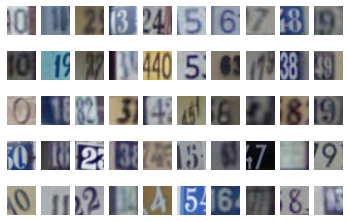

In [4]:
samples_per_class = 5
digits_count = 10
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(digits_count):
        plt.subplot(samples_per_class, digits_count, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

In [5]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat

In [6]:
train_X, test_X = prepare_for_neural_network(train_X, test_X)

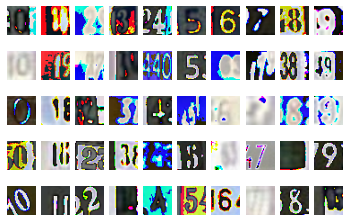

In [7]:
samples_per_class = 5
digits_count = 10
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(digits_count):
        plt.subplot(samples_per_class, digits_count, plot_index)
        image = train_X[train_y == class_index][example_index].reshape(32, 32, 3) * 255.0
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

In [8]:
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [9]:
X = np.array([[1,-2,3], [-1, 2, 0.1]])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [10]:
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)

Gradient check passed!


In [11]:
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [12]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

In [13]:
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W0
Gradient check passed!
Checking gradient for B0
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [14]:
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W0
Gradient check passed!
Checking gradient for B0
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [15]:
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [16]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD())

loss_history, train_history, val_history = trainer.fit()

Loss: 2.217215, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.155566, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.101459, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286570, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.170695, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.067441, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.367471, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.110023, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.226594, Train accuracy: 0.207667, val accuracy: 0.215000
Loss: 2.068688, Train accuracy: 0.230111, val accuracy: 0.235000
Loss: 2.120957, Train accuracy: 0.256444, val accuracy: 0.258000
Loss: 2.110639, Train accuracy: 0.268778, val accuracy: 0.268000
Loss: 2.121036, Train accuracy: 0.282556, val accuracy: 0.287000
Loss: 1.999364, Train accuracy: 0.300111, val accuracy: 0.306000
Loss: 2.058220, Train accuracy: 0.322222, val accuracy: 0.325000
Loss: 1.853882, Train acc

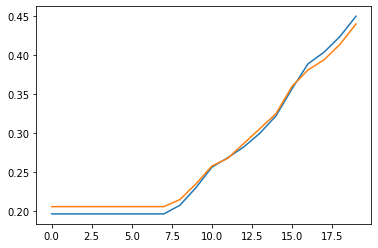

In [17]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [18]:
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.246074, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.372562, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.209350, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.260245, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.182553, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.195048, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.086410, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321902, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.248486, Train accuracy: 0.200889, val accuracy: 0.210000
Loss: 2.193291, Train accuracy: 0.225889, val accuracy: 0.230000
Loss: 2.084251, Train accuracy: 0.241111, val accuracy: 0.242000
Loss: 2.093536, Train accuracy: 0.268000, val accuracy: 0.267000
Loss: 2.380028, Train accuracy: 0.276667, val accuracy: 0.271000
Loss: 1.764889, Train accuracy: 0.280556, val accuracy: 0.286000
Loss: 2.301798, Train accuracy: 0.299778, val accuracy: 0.306000
Loss: 1.942206, Train acc

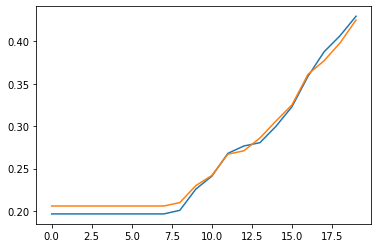

In [19]:
plt.plot(train_history)
plt.plot(val_history)

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [20]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate_decay=0.99)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.150784, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.685559, Train accuracy: 0.342222, val accuracy: 0.347000
Loss: 1.407328, Train accuracy: 0.532778, val accuracy: 0.530000
Loss: 1.515136, Train accuracy: 0.601000, val accuracy: 0.592000
Loss: 1.385950, Train accuracy: 0.666444, val accuracy: 0.640000
Loss: 1.675235, Train accuracy: 0.661000, val accuracy: 0.656000
Loss: 1.065633, Train accuracy: 0.708000, val accuracy: 0.672000
Loss: 1.048001, Train accuracy: 0.712889, val accuracy: 0.665000
Loss: 1.338748, Train accuracy: 0.726667, val accuracy: 0.692000
Loss: 1.371619, Train accuracy: 0.738444, val accuracy: 0.696000
Loss: 0.742175, Train accuracy: 0.769889, val accuracy: 0.706000
Loss: 0.866305, Train accuracy: 0.772556, val accuracy: 0.705000
Loss: 0.841246, Train accuracy: 0.795889, val accuracy: 0.714000
Loss: 0.597965, Train accuracy: 0.779778, val accuracy: 0.712000
Loss: 1.439451, Train accuracy: 0.797000, val accuracy: 0.731000
Loss: 1.040094, Train acc

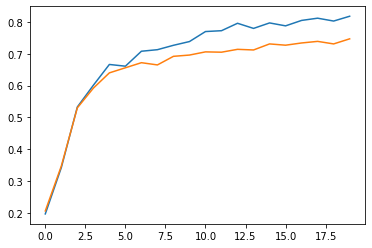

In [21]:
plt.plot(train_history)
plt.plot(val_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [22]:
data_size = 15

In [23]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.351801, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319693, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.295926, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.345443, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.310013, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.326544, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.255641, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.199259, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.164561, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.025661, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.883798, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.263931, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.662918, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.245522, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.943906, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.663953, Train acc

Loss: 1.229377, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.400568, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.391042, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.102808, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.445285, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.406323, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.219193, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.449330, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.304464, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.494726, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.327706, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.361608, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.460816, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.424061, Train accuracy: 1.000000, val accuracy: 0.000000


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [24]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=2)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.272250, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.402384, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.152894, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.492717, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.451307, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 0.499127, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 0.849219, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 0.994072, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 0.185239, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.344582, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 2.273367, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 2.400255, Train accuracy: 0.666667, val accuracy: 0.066667
Loss: 1.261310, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.150397, Train accuracy: 0.666667, val accuracy: 0.133333
Loss: 0.074912, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 1.175889, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [25]:
dataset = Dataset(train_X, train_y, val_X, val_y)

In [26]:
hidden_layer_size = 10
learning_rate_decay = 0.99
batch_size = 16
num_epochs = 50

reg_strengths = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
learning_rates = [1e-2, 5e-3, 1e-3]

best_val_accuracy = None

for reg_strength in reg_strengths:
    for learning_rate in learning_rates:
        model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                            hidden_layer_size=hidden_layer_size, reg=reg_strength)
        trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate, 
                          learning_rate_decay=learning_rate_decay, 
                          num_epochs=num_epochs, batch_size=batch_size)
        loss_history, train_history, val_history = trainer.fit(out=False)
        accuracy = val_history[-1]
        if best_val_accuracy is None or best_val_accuracy < accuracy:
            best_val_accuracy = accuracy
            best_reg_strength = reg_strength
            best_learning_rate = learning_rate
        print('R_S =', reg_strength, flush=True)
        print('L_R =', learning_rate, flush=True)
        print('ACC =', accuracy, flush=True)
        
print('*****************************', flush=True)
print('BEST R_S =', best_reg_strength, flush=True)
print('BEST L_R =', best_learning_rate, flush=True)
print('BEST ACC =', best_val_accuracy, flush=True)

100%|██████████| 50/50 [00:25<00:00,  1.92it/s]

R_S = 0.01
L_R = 0.01
ACC = 0.541



100%|██████████| 50/50 [00:26<00:00,  1.91it/s]

R_S = 0.01
L_R = 0.005
ACC = 0.557



100%|██████████| 50/50 [00:25<00:00,  1.92it/s]

R_S = 0.01
L_R = 0.001
ACC = 0.497



100%|██████████| 50/50 [00:26<00:00,  1.92it/s]

R_S = 0.001
L_R = 0.01
ACC = 0.587



100%|██████████| 50/50 [00:26<00:00,  1.92it/s]

R_S = 0.001
L_R = 0.005
ACC = 0.581



100%|██████████| 50/50 [00:26<00:00,  1.91it/s]

R_S = 0.001
L_R = 0.001
ACC = 0.525



100%|██████████| 50/50 [00:26<00:00,  1.92it/s]

R_S = 0.0001
L_R = 0.01
ACC = 0.59



100%|██████████| 50/50 [00:26<00:00,  1.92it/s]

R_S = 0.0001
L_R = 0.005
ACC = 0.617



100%|██████████| 50/50 [00:25<00:00,  1.93it/s]

R_S = 0.0001
L_R = 0.001
ACC = 0.513



100%|██████████| 50/50 [00:25<00:00,  1.92it/s]

R_S = 1e-05
L_R = 0.01
ACC = 0.618



100%|██████████| 50/50 [00:26<00:00,  1.91it/s]

R_S = 1e-05
L_R = 0.005
ACC = 0.6



100%|██████████| 50/50 [00:26<00:00,  1.92it/s]

R_S = 1e-05
L_R = 0.001
ACC = 0.554



100%|██████████| 50/50 [00:26<00:00,  1.92it/s]

R_S = 1e-06
L_R = 0.01
ACC = 0.589



100%|██████████| 50/50 [00:25<00:00,  1.92it/s]

R_S = 1e-06
L_R = 0.005
ACC = 0.631



100%|██████████| 50/50 [00:26<00:00,  1.90it/s]

R_S = 1e-06
L_R = 0.001
ACC = 0.563
*****************************
BEST R_S = 1e-06
BEST L_R = 0.005
BEST ACC = 0.631


In [27]:
learning_rate = best_learning_rate
reg_strength = best_reg_strength

hidden_layer_size = 10
batch_size = 16
num_epochs = 50

learning_rate_decays = [1 - 0.005 * i for i in range(1, 21)]

best_val_accuracy = None

for learning_rate_decay in learning_rate_decays:
    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                        hidden_layer_size=hidden_layer_size, reg=reg_strength)
    trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate, 
                      learning_rate_decay=learning_rate_decay, 
                      num_epochs=num_epochs, batch_size=batch_size)
    loss_history, train_history, val_history = trainer.fit(out=False)
    accuracy = val_history[-1]
    if best_val_accuracy is None or best_val_accuracy < accuracy:
        best_val_accuracy = accuracy
        best_learning_rate_decay = learning_rate_decay
    print('LRD =', learning_rate_decay, flush=True)
    print('ACC =', accuracy, flush=True)
        
print('*****************************', flush=True)
print('BEST LRD =', best_learning_rate_decay, flush=True)
print('BEST ACC =', best_val_accuracy, flush=True)

100%|██████████| 50/50 [00:25<00:00,  2.00it/s]

LRD = 0.995
ACC = 0.571



100%|██████████| 50/50 [00:25<00:00,  1.99it/s]

LRD = 0.99
ACC = 0.631



100%|██████████| 50/50 [00:24<00:00,  2.00it/s]

LRD = 0.985
ACC = 0.616



100%|██████████| 50/50 [00:25<00:00,  2.00it/s]

LRD = 0.98
ACC = 0.62



100%|██████████| 50/50 [00:25<00:00,  1.96it/s]

LRD = 0.975
ACC = 0.617



100%|██████████| 50/50 [00:25<00:00,  1.95it/s]

LRD = 0.97
ACC = 0.623



100%|██████████| 50/50 [00:25<00:00,  1.94it/s]

LRD = 0.965
ACC = 0.609



100%|██████████| 50/50 [00:25<00:00,  1.94it/s]

LRD = 0.96
ACC = 0.637



100%|██████████| 50/50 [00:25<00:00,  1.95it/s]

LRD = 0.955
ACC = 0.62



100%|██████████| 50/50 [00:26<00:00,  1.88it/s]

LRD = 0.95
ACC = 0.589



100%|██████████| 50/50 [00:32<00:00,  1.54it/s]

LRD = 0.945
ACC = 0.615



100%|██████████| 50/50 [00:36<00:00,  1.37it/s]

LRD = 0.94
ACC = 0.592



100%|██████████| 50/50 [00:27<00:00,  1.80it/s]

LRD = 0.935
ACC = 0.604



100%|██████████| 50/50 [00:25<00:00,  1.96it/s]

LRD = 0.9299999999999999
ACC = 0.596



100%|██████████| 50/50 [00:25<00:00,  1.99it/s]

LRD = 0.925
ACC = 0.634



100%|██████████| 50/50 [00:25<00:00,  1.99it/s]

LRD = 0.92
ACC = 0.572



100%|██████████| 50/50 [00:25<00:00,  1.99it/s]

LRD = 0.915
ACC = 0.601



100%|██████████| 50/50 [00:25<00:00,  1.97it/s]

LRD = 0.91
ACC = 0.616



100%|██████████| 50/50 [00:25<00:00,  1.99it/s]

LRD = 0.905
ACC = 0.599



100%|██████████| 50/50 [00:25<00:00,  1.99it/s]

LRD = 0.9
ACC = 0.598
*****************************
BEST LRD = 0.96
BEST ACC = 0.637


In [28]:
learning_rate = best_learning_rate
reg_strength = best_reg_strength
learning_rate_decay = best_learning_rate_decay

hidden_layer_size = 10
num_epochs = 50

batch_sizes = [2 ** i for i in range(3, 9)]

best_val_accuracy = None

for batch_size in batch_sizes:
    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                        hidden_layer_size=hidden_layer_size, reg=reg_strength)
    trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate, 
                      learning_rate_decay=learning_rate_decay, 
                      num_epochs=num_epochs, batch_size=batch_size)
    loss_history, train_history, val_history = trainer.fit(out=False)
    accuracy = val_history[-1]
    if best_val_accuracy is None or best_val_accuracy < accuracy:
        best_val_accuracy = accuracy
        best_batch_size = batch_size
    print('B_S =', batch_size, flush=True)
    print('ACC =', accuracy, flush=True)
        
print('*****************************', flush=True)
print('BEST B_S =', best_batch_size, flush=True)
print('BEST ACC =', best_val_accuracy, flush=True)

100%|██████████| 50/50 [00:22<00:00,  2.23it/s]

B_S = 8
ACC = 0.634



100%|██████████| 50/50 [00:25<00:00,  1.96it/s]

B_S = 16
ACC = 0.605



100%|██████████| 50/50 [00:20<00:00,  2.42it/s]

B_S = 32
ACC = 0.614



100%|██████████| 50/50 [00:15<00:00,  3.21it/s]

B_S = 64
ACC = 0.469



100%|██████████| 50/50 [00:11<00:00,  4.38it/s]

B_S = 128
ACC = 0.276



100%|██████████| 50/50 [00:11<00:00,  4.24it/s]

B_S = 256
ACC = 0.206
*****************************
BEST B_S = 8
BEST ACC = 0.634


In [29]:
learning_rate = best_learning_rate
reg_strength = best_reg_strength
learning_rate_decay = best_learning_rate_decay
batch_size = best_batch_size

num_epochs = 50

hidden_layer_sizes = [2 ** i for i in range(3, 9)]

best_val_accuracy = None

for hidden_layer_size in hidden_layer_sizes:
    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                        hidden_layer_size=hidden_layer_size, reg=reg_strength)
    trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate, 
                      learning_rate_decay=learning_rate_decay, 
                      num_epochs=num_epochs, batch_size=batch_size)
    loss_history, train_history, val_history = trainer.fit(out=False)
    accuracy = val_history[-1]
    if best_val_accuracy is None or best_val_accuracy < accuracy:
        best_val_accuracy = accuracy
        best_hidden_layer_size = hidden_layer_size
    print('HLS =', hidden_layer_size, flush=True)
    print('ACC =', accuracy, flush=True)
        
print('*****************************', flush=True)
print('BEST HLS =', best_hidden_layer_size, flush=True)
print('BEST ACC =', best_val_accuracy, flush=True)

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]

HLS = 8
ACC = 0.593



100%|██████████| 50/50 [00:49<00:00,  1.01it/s]

HLS = 16
ACC = 0.685



100%|██████████| 50/50 [01:08<00:00,  1.36s/it]

HLS = 32
ACC = 0.723



100%|██████████| 50/50 [02:16<00:00,  2.73s/it]

HLS = 64
ACC = 0.76



100%|██████████| 50/50 [06:35<00:00,  7.91s/it]

HLS = 128
ACC = 0.76



100%|██████████| 50/50 [12:21<00:00, 14.84s/it]

HLS = 256
ACC = 0.777
*****************************
BEST HLS = 256
BEST ACC = 0.777


In [30]:
learning_rate = best_learning_rate
reg_strength = best_reg_strength
learning_rate_decay = best_learning_rate_decay
batch_size = best_batch_size
hidden_layer_size = best_hidden_layer_size

nums_epochs = [50 * i for i in range(1, 7)]

best_val_accuracy = None

for num_epochs in nums_epochs:
    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                        hidden_layer_size=hidden_layer_size, reg=reg_strength)
    trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate, 
                      learning_rate_decay=learning_rate_decay, 
                      num_epochs=num_epochs, batch_size=batch_size)
    loss_history, train_history, val_history = trainer.fit(out=False)
    accuracy = val_history[-1]
    if best_val_accuracy is None or best_val_accuracy < accuracy:
        best_val_accuracy = accuracy
        best_num_epochs = num_epochs
    print('N_E =', num_epochs, flush=True)
    print('ACC =', accuracy, flush=True)
        
print('*****************************', flush=True)
print('BEST N_E =', best_num_epochs, flush=True)
print('BEST ACC =', best_val_accuracy, flush=True)

100%|██████████| 50/50 [11:17<00:00, 13.55s/it]

N_E = 50
ACC = 0.774



100%|██████████| 100/100 [24:32<00:00, 14.72s/it]

N_E = 100
ACC = 0.789



100%|██████████| 150/150 [36:48<00:00, 14.73s/it]

N_E = 150
ACC = 0.776



100%|██████████| 200/200 [45:15<00:00, 13.58s/it]

N_E = 200
ACC = 0.78



100%|██████████| 250/250 [1:01:16<00:00, 14.70s/it]

N_E = 250
ACC = 0.786



100%|██████████| 300/300 [1:13:42<00:00, 14.74s/it]

N_E = 300
ACC = 0.782
*****************************
BEST N_E = 100
BEST ACC = 0.789


In [31]:
best_classifier = TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                    hidden_layer_size=best_hidden_layer_size, reg=best_reg_strength)
trainer = Trainer(best_classifier, dataset, MomentumSGD(), learning_rate=best_learning_rate, 
                  learning_rate_decay=best_learning_rate_decay, 
                  num_epochs=best_num_epochs, batch_size=best_batch_size)

loss_history, train_history, val_history = trainer.fit(out=False)
best_val_accuracy = val_history[-1]

print('best validation accuracy achieved: %f' % best_val_accuracy)

100%|██████████| 100/100 [25:40<00:00, 15.40s/it]

best validation accuracy achieved: 0.771000


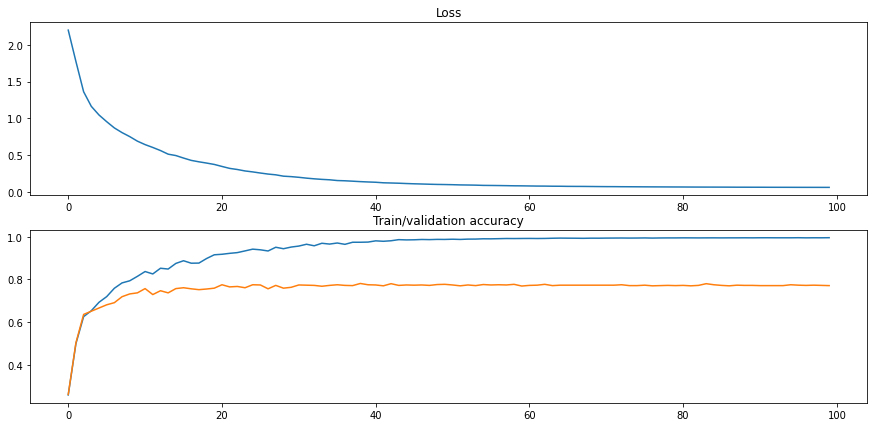

In [32]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [33]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.761000


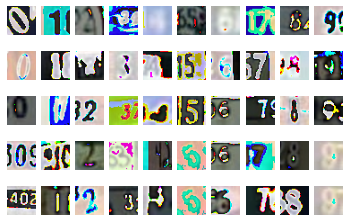

Predicted:
[[3 1 2 8 4 5 6 7 8 9]
 [6 1 2 3 3 5 6 7 8 2]
 [9 1 2 3 4 5 2 7 4 9]
 [0 1 2 3 3 9 2 7 8 9]
 [8 1 2 5 9 9 6 7 8 9]]


In [85]:
samples_per_class = 5
digits_count = 10

preds = []

for index in range(samples_per_class):
    for digit in range(digits_count):
        digit_indices = test_y == digit
        test_X_cur = test_X[digit_indices]
        test_y_cur = test_y[digit_indices]

        test_indices = np.arange(test_y_cur.size)
        random_indices = np.random.choice(test_indices)

        image = test_X_cur[random_indices]
        pred = best_classifier.predict(image)
        preds.append(pred)
        
        image = image.reshape(32, 32, 3) * 255.0
    
        plt.subplot(samples_per_class, digits_count, index * digits_count + digit + 1)
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1
        
plt.show()

preds = np.array(preds).reshape(samples_per_class, digits_count)
print('Predicted:\n' + str(preds))
